In [1]:

import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
# from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import os
from openslide import OpenSlide, deepzoom
import random
from scipy.ndimage import binary_fill_holes

In [2]:
import matplotlib.pyplot as plt
%matplotlib qt

In [4]:
df = pd.read_csv('train_10x_512_sc.csv', sep="\t")

patient = list(np.unique(df['PATIENT_ID']))
random.seed(1024)
random.shuffle(patient)
n_patient = len(patient)

df['fold'] = -1
for i in range(n_patient//100+1):
    train_patient = patient[i*100:(i+1)*100]
    df.loc[df.PATIENT_ID.isin(train_patient), 'fold'] = i
df.to_csv('train_10x_512_sc_fold.csv', index=None, sep='\t')

In [7]:
df.shape, n_patient

((732, 21), 475)

In [3]:
data_dir = '/mnt/data/tcga/dataset/'
image_folder = data_dir + 'imgs'
patch_folder = data_dir + "img_patch_512_10x"

df_train = pd.read_csv('/mnt/data/tcga/dataset/tcga.csv', sep=',')
df = df_train.reset_index(drop=True)
df.head()

#label
df['label'] = 0
df.loc[(df['PATHOLOGY']=='TCGA-LUSC') & (df['SAMPLE_TYPE']!="Solid Tissue Normal"), "label"]=2
df.loc[(df['PATHOLOGY']=='TCGA-LUAD') & (df['SAMPLE_TYPE']!="Solid Tissue Normal"), "label"]=1

#filter
df = df[df['TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT']==1]
# df = df[df['PATHOLOGY']=='TCGA-LUAD']

#fold
patient = list(np.unique(df['PATIENT_ID']))
random.seed(1024)
random.shuffle(patient)
n_patient = len(patient)
train_patient = patient[:n_patient-300]
val_patient = patient[-300:-150]
test_patient = patient[-150:]

df['fold'] = -1
df.loc[df.PATIENT_ID.isin(train_patient), 'fold'] = 0
df.loc[df.PATIENT_ID.isin(val_patient), 'fold'] = 1
df.loc[df.PATIENT_ID.isin(test_patient), 'fold'] = 2

print(df.shape)
df.head()


(1504, 12)


,TCGA-CODE,FILE_NAME,SLICE_TYPE,PATHOLOGY,PATIENT_ID,SAMPLE_ID,SAMPLE_TYPE,TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT,TMB_SAMPLE,TMB_38Mb,label,fold
1,76e57a63-36bf-462f-9691-ba7a89b9c068,TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,Tissue Slide,TCGA-LUSC,TCGA-XC-AA0X,TCGA-XC-AA0X-01A-03,Primary Solid Tumor,1.0,TCGA-XC-AA0X-01A-32D-A401-08,2.815789,2,2
3,7444a1e1-61ed-4cae-a075-44613cf8e3c7,TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,Tissue Slide,TCGA-LUAD,TCGA-S2-AA1A,TCGA-S2-AA1A-01A-01,Primary Solid Tumor,1.0,TCGA-S2-AA1A-01A-12D-A397-08,2.447368,1,1
5,64469ef0-120a-422b-a9a7-d8ccb4bf0efb,TCGA-O2-A5IB-01A-01-TS1.C35BA437-7DF7-4C5C-8D4...,Tissue Slide,TCGA-LUSC,TCGA-O2-A5IB,TCGA-O2-A5IB-01A-01,Primary Solid Tumor,1.0,TCGA-O2-A5IB-01A-11D-A27K-08,6.394737,2,0
7,f8b9f7a8-2eb5-4710-a1cc-237a438588f9,TCGA-O2-A52W-01A-01-TS1.9AFB0258-8E79-4108-BBE...,Tissue Slide,TCGA-LUSC,TCGA-O2-A52W,TCGA-O2-A52W-01A-01,Primary Solid Tumor,1.0,TCGA-O2-A52W-01A-11D-A26M-08,2.605263,2,0
9,470f6c06-a625-430b-a03a-034333d9780e,TCGA-O2-A52V-01A-03-TSC.BA28F714-8AEE-47B6-844...,Tissue Slide,TCGA-LUSC,TCGA-O2-A52V,TCGA-O2-A52V-01A-03,Primary Solid Tumor,1.0,TCGA-O2-A52V-01A-31D-A25L-08,5.447368,2,2


In [4]:
# from openslide import deepzoom
i = 71
row = df.iloc[i]
file_name = str(row.FILE_NAME)

tiff_file = os.path.join(image_folder, file_name)
image = OpenSlide(tiff_file)
print(image.properties)
tiles = deepzoom.DeepZoomGenerator(image, tile_size=512, overlap=0)
print(tiles.level_dimensions)
print(tiles.level_tiles[tiles.level_count-2])

<_PropertyMap {'aperio.AppMag': '40', 'aperio.DSR ID': 'resc3-dsr2', 'aperio.Date': '10/11/12', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': 'TCGA-L4-A4E5-01A-01-TSA', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '116286', 'aperio.Left': '24.444542', 'aperio.LineAreaXOffset': '-0.014041', 'aperio.LineAreaYOffset': '0.000544', 'aperio.LineCameraSkew': '0.000833', 'aperio.MPP': '0.2485', 'aperio.OriginalHeight': '26144', 'aperio.OriginalWidth': '113000', 'aperio.Parmset': 'GOG136 on RESBPCLACIE02', 'aperio.ScanScope ID': 'SS1436CNTLR', 'aperio.StripeWidth': '1000', 'aperio.Time': '08:59:42', 'aperio.Time Zone': 'GMT-04:00', 'aperio.Title': 'TCGA-L4-A4E5-01A-01-TSA', 'aperio.Top': '16.419918', 'aperio.User': 'a0acc3ad-2baf-40f6-8e13-67d4f0dbb4bb', 'openslide.comment': 'Aperio Image Library v10.2.41\r\n113000x26144 [0,100 108207x26044] (256x256) JPEG/RGB Q=30|AppMag = 40|Str

In [6]:
def crop_save(path, size=512, target_mag=10):
    image = OpenSlide(path)
    try:
        AppMag = image.properties['aperio.AppMag']
        MPP = image.properties['openslide.mpp-x']
        
    except:
        res = {"filename": os.path.basename(path), "AppMag":0 ,"MMP": 0,\
                "dimensions":tuple(image.level_dimensions[0]),  "sums":{0:0}, "n":0}#"prob":str(image.properties),
        return res
    
    sums_all = {}
    area_ratio = {}
    xy = {}
    valide_id = []
#     scale = scale_d if AppMag=="20" else 2*scale_d
#     boxes = get_box_naive(image.level_dimensions[0], size*scale)
#     print(path, len(boxes))
    if AppMag=="20":  
        target_level = -2
    elif AppMag=="40": 
        target_level = -3

    tiles = deepzoom.DeepZoomGenerator(image, tile_size=512, overlap=0)
    level = tiles.level_count + target_level
    xx, yy = tiles.level_tiles[level]
    i = 0
    for x in range(xx): 
        for y in range(yy):
            img = tiles.get_tile(level, (x, y))
            img = np.array(img)[:,:,:3]
            #cal img ratio
            h, w = img.shape[0], img.shape[1]
            if h!=512:
                img = np.pad(img, ((0, 512-h), (0,0), (0,0)), 'constant', constant_values=255)
            elif w!=512: 
                img = np.pad(img, ((0, 0), (0,512-w), (0,0)), 'constant', constant_values=255)
            channel_averaged_img = img > 220
            binary_img = np.sum(channel_averaged_img, axis=-1) < 3
            ar = binary_img.sum() / 512. / 512.
            area_ratio.update({i:ar})
            #xy
            xy.update({i:(x, y)})
            if ar>0.5:
                valide_id.append(i)
                cv2.imwrite(os.path.join(patch_folder, os.path.basename(path).replace('.svs', f'_{i}.png')), img)
            i+=1
    res = {"filename": os.path.basename(path), "AppMag":AppMag ,"MMP": MPP,\
            "dimensions":tuple(image.level_dimensions[0]), 'xy':xy, 'area_ratio':area_ratio,
           'valide_ids':valide_id, 'valide_n':len(valide_id), 'tile_shape': (xx, yy)}#"prob":str(image.properties),
    return res

In [7]:
print(len(df[df['fold']==0]))
print(len(df[df['fold']==1]))
print(len(df[df['fold']==2]))
print(len(np.unique(df[df['fold']==0]['PATIENT_ID'])))
print(len(np.unique(df[df['fold']==1]['PATIENT_ID'])))
print(len(np.unique(df[df['fold']==2]['PATIENT_ID'])))

1060
231
213
668
150
150


In [8]:
df = df[df['PATHOLOGY']=='TCGA-LUSC']

In [9]:
from tqdm import tqdm_notebook as tqdm
import multiprocessing
pool = multiprocessing.Pool(processes = 8)
res = []
pbar = tqdm(total=len(df))
def update(*a):
#     print(a)
    res.append(a[0])
    pbar.update()
    
for i in range(len(df)):
    row = df.iloc[i]
    file_name = str(row.FILE_NAME)

    tiff_file = os.path.join(image_folder, file_name)
    pool.apply_async(crop_save, (tiff_file, ), callback=update)
pool.close()
pool.join() 

In [10]:
len(res)

732

In [11]:
res_dict =  {}
for i, r in enumerate(res):
    res_dict.update({i:r})
    
res_df = pd.DataFrame.from_dict(res_dict, orient="index")
res_df.head()

,filename,AppMag,MMP,dimensions,xy,area_ratio,valide_ids,valide_n,tile_shape
0,TCGA-O2-A5IB-01A-01-TS1.C35BA437-7DF7-4C5C-8D4...,40,0.2485,"(120656, 32348)","{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4...","{0: 0.000148773193359375, 1: 0.00018310546875,...","[53, 54, 55, 56, 70, 71, 72, 86, 87, 88, 89, 1...",250,"(59, 16)"
1,TCGA-NK-A5D1-01A-01-TS1.4CD93F36-615F-4B93-819...,40,0.24679999999999999,"(29512, 17392)","{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4...","{0: 0.0, 1: 2.6702880859375e-05, 2: 0.0, 3: 0....","[29, 30, 47, 55, 56, 58, 64, 65, 66, 67, 73, 7...",22,"(15, 9)"
2,TCGA-O2-A52Q-01A-01-TSA.1C75AE48-43E2-49E6-A49...,40,0.24560000000000001,"(75208, 26277)","{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4...","{0: 0.001224517822265625, 1: 0.000705718994140...","[41, 42, 43, 44, 45, 54, 55, 56, 57, 58, 59, 6...",96,"(37, 13)"
3,TCGA-O2-A52W-01A-01-TS1.9AFB0258-8E79-4108-BBE...,40,0.2465,"(82824, 28710)","{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4...","{0: 3.0517578125e-05, 1: 2.288818359375e-05, 2...","[22, 23, 24, 36, 37, 38, 39, 40, 48, 50, 51, 5...",94,"(41, 15)"
4,TCGA-NK-A5CX-01A-01-TS1.AB708497-54B8-4AA5-A72...,40,0.2465,"(85680, 24894)","{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4...","{0: 5.340576171875e-05, 1: 4.1961669921875e-05...","[20, 21, 31, 32, 33, 34, 35, 44, 45, 46, 47, 4...",68,"(42, 13)"


In [12]:
df_ready = pd.merge(left=res_df, right=df, left_on="filename", right_on="FILE_NAME")


In [14]:
df_sd = pd.read_csv('train_10x_512_n.csv', sep="\t")
df_ready1 = pd.concat([df_ready, df_sd], axis=0)

In [17]:
df_ready1.shape, df_ready.shape,df_sd.shape

((1504, 21), (732, 21), (772, 21))

In [18]:
df_ready.to_csv("train_10x_512_sc.csv", index=None, sep="\t")

In [14]:
plt.hist(df_ready['valide_n'])

(array([438., 232.,  52.,  26.,   9.,   6.,   2.,   3.,   3.,   1.]),
 array([   2. ,  139.3,  276.6,  413.9,  551.2,  688.5,  825.8,  963.1,
        1100.4, 1237.7, 1375. ]),
 <a list of 10 Patch objects>)

In [15]:
#(90035, 18567, 19904)
df_ready[df_ready['fold']==0]['valide_n'].sum(), df_ready[df_ready['fold']==1]['valide_n'].sum(), df_ready[df_ready['fold']==2]['valide_n'].sum()

(90204, 18586, 19935)

In [16]:
#534, 109, 117 = 760
#535, 117, 119 = 771
df_ready[df_ready['fold']==0]['valide_n'].count(), df_ready[df_ready['fold']==1]['valide_n'].count(), df_ready[df_ready['fold']==2]['valide_n'].count()

(536, 117, 119)

In [ ]:
df_ready.head()

In [17]:
patient_df = df_ready.drop_duplicates(subset='PATIENT_ID')

In [19]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=10,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=3
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)#, fill=color
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

#     if top > total_display_str_height:
#         text_bottom = top
#     else:
#         text_bottom = bottom + total_display_str_height
    text_bottom = (top+bottom)//2
    left = (left + right)//2
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)])
        draw.text((left + margin-text_width//2, text_bottom - text_height//2 - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin
def xywh2xyxy(x, y, w, h, scale):
    return [x/scale, y/scale, (x+w)/scale, (y+h)/scale]


In [101]:
i=1
row = df.iloc[i]
file_name = str(row.FILE_NAME)
tiff_file = os.path.join(image_folder, file_name)
infos = crop_save(tiff_file)

In [102]:
def plot_boxes(i):
    row = df.iloc[i]
    file_name = str(row.FILE_NAME)
    tiff_file = os.path.join(image_folder, file_name)
    image = OpenSlide(tiff_file)
    level_downsample = image.level_downsamples[-1]
    
    try:
        AppMag = image.properties['aperio.AppMag']
    except:
        return
    scale = int(level_downsample / (int(AppMag) / 10))
    scale_0 = (int(AppMag) / 10)
#     box_hw = 512
#     infos = crop_save(tiff_file)
    img = np.array(image.read_region((0,0), image.level_count-1, image.level_dimensions[-1]))[:,:,:3]
    img = Image.fromarray(img)
#     img.show()
    for k, v in infos['xy'].items():
        if not k in infos['valide_ids']: continue
        x1,y1,x2,y2 = xywh2xyxy(v[0]/scale_0, v[1]/scale_0, 512, 512, scale)
#         print(x1, y1,x2,y2)
        draw_bounding_box_on_image(img, int(x1),int(y1),int(x2),int(y2), color=(255,0,255))#, display_str_list=(str(k),)
#         draw_bounding_box_on_image(img, int(y1),int(x1),int(y2),int(x2), color=(0,0,255))#, display_str_list=(str(k),)
#         break
#         cv2.rectangle((x1, y1), (x2, y2), img, 2)
    plt.imshow(img)

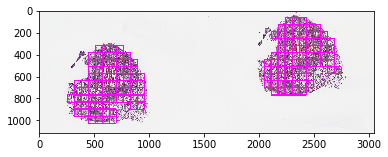

In [103]:
plot_boxes(i)

In [27]:
df = pd.read_csv("train_20x_1024.csv", sep="\t")
df[["filename","fold","label","TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT","PATHOLOGY","SAMPLE_TYPE","TMB_38Mb"]].head()

,filename,fold,label,TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT,PATHOLOGY,SAMPLE_TYPE,TMB_38Mb
0,TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,1,1,1.0,TCGA-LUAD,Primary Solid Tumor,2.447368
1,TCGA-O2-A52W-01A-01-TS1.9AFB0258-8E79-4108-BBE...,1,2,1.0,TCGA-LUSC,Primary Solid Tumor,2.605263
2,TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,1,2,1.0,TCGA-LUSC,Primary Solid Tumor,2.815789
3,TCGA-O2-A5IB-01A-01-TS1.C35BA437-7DF7-4C5C-8D4...,1,2,1.0,TCGA-LUSC,Primary Solid Tumor,6.394737
4,TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7...,1,2,2.0,TCGA-LUSC,Primary Solid Tumor,2.815789


In [31]:
df_ready = pd.merge(left=res_df, right=df[["filename","fold","label","TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT","PATHOLOGY","SAMPLE_TYPE","TMB_38Mb"]], on="filename")
df_ready.to_csv("train_10x_512.csv", index=None, sep="\t")

In [39]:
df_sample12 = df_ready[(df_ready["TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT"]==1)|(df_ready["TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT"]==2)]

In [41]:
df_ad = df_sample12[df_sample12['label']==1]
df_sc = df_sample12[df_sample12['label']==2]

In [42]:
df_ad.shape, df_sc.shape

((1329, 14), (1232, 14))

In [43]:
df_ad[df_ad['fold']==0].shape, df_sc[df_sc['fold']==0].shape

((235, 14), (250, 14))

In [11]:
res_df.to_csv("crop_img_512.csv")

In [19]:
df['label'] = 0
df.loc[(df['PATHOLOGY']=='TCGA-LUSC') & (df['SAMPLE_TYPE']!="Solid Tissue Normal"), "label"]=2
df.loc[(df['PATHOLOGY']=='TCGA-LUAD') & (df['SAMPLE_TYPE']!="Solid Tissue Normal"), "label"]=1

In [36]:
df_crop_dimension1 = pd.merge(left=res_df, right=df_labeled, left_on="filename", right_on="FILE_NAME")

In [38]:
df_crop_dimension1.shape

(3220, 13)

In [41]:
df_crop_dimension1.to_csv("crop_dimension1_1024.csv", index=None, sep="\t")

In [25]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5, random_state=1080)
df['fold'] = -1
for i, (train_index, test_index) in enumerate(skf.split(df, (df['label'], df['PATIENT_ID']))):
    df.loc[test_index, 'fold'] = i
df.head()

/home/hy/anaconda3/envs/torch-env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  n_classes = len(y_idx)


,TCGA-CODE,FILE_NAME,SLICE_TYPE,PATHOLOGY,PATIENT_ID,SAMPLE_ID,SAMPLE_TYPE,TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT,TMB_SAMPLE,TMB_38Mb,fold,label
0,dfc4dcdf-2893-446e-adc6-a5a54f1bde4c,TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7...,Diagnostic Slide,TCGA-LUSC,TCGA-XC-AA0X,TCGA-XC-AA0X-01Z-00,Primary Solid Tumor,2.0,TCGA-XC-AA0X-01A-32D-A401-08,2.815789,0,2
1,76e57a63-36bf-462f-9691-ba7a89b9c068,TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,Tissue Slide,TCGA-LUSC,TCGA-XC-AA0X,TCGA-XC-AA0X-01A-03,Primary Solid Tumor,1.0,TCGA-XC-AA0X-01A-32D-A401-08,2.815789,1,2
2,e15d5e52-c2a5-405c-9e19-fcc9b1252ab5,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,Diagnostic Slide,TCGA-LUAD,TCGA-S2-AA1A,TCGA-S2-AA1A-01Z-00,Primary Solid Tumor,2.0,TCGA-S2-AA1A-01A-12D-A397-08,2.447368,0,1
3,7444a1e1-61ed-4cae-a075-44613cf8e3c7,TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,Tissue Slide,TCGA-LUAD,TCGA-S2-AA1A,TCGA-S2-AA1A-01A-01,Primary Solid Tumor,1.0,TCGA-S2-AA1A-01A-12D-A397-08,2.447368,1,1
4,5fd57ccd-039e-4a88-9103-6deb031ef3e9,TCGA-O2-A5IB-01Z-00-DX1.E34D0FEC-A9D3-4F7F-997...,Diagnostic Slide,TCGA-LUSC,TCGA-O2-A5IB,TCGA-O2-A5IB-01Z-00,Primary Solid Tumor,2.0,TCGA-O2-A5IB-01A-11D-A27K-08,6.394737,0,2


In [9]:
row = df.iloc[3114]
file_name = row.FILE_NAME
tiff_file = os.path.join(image_folder, file_name)
image = OpenSlide(tiff_file)

In [8]:

infos = []
for i in range(len(df)):
    row = df.iloc[i]
    file_name = row.FILE_NAME
    tiff_file = os.path.join(image_folder, file_name)
    image = OpenSlide(tiff_file)
    level_count = image.level_count
    level_dimensions_0 = image.level_dimensions[0][0]
    level_dimensions_1 = image.level_dimensions[0][1]
    try:
        appmag = image.properties['aperio.AppMag']
        infos.append(appmag)
    except:
        print(i)
        print(image.properties)

3114
<_PropertyMap {'openslide.comment': 'Aperio Image Library v12.1.3 \r\n8320x10000 (256x256) J2K/KDU Q=70', 'openslide.level-count': '2', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '10000', 'openslide.level[0].tile-height': '256', 'openslide.level[0].tile-width': '256', 'openslide.level[0].width': '8320', 'openslide.level[1].downsample': '4', 'openslide.level[1].height': '2500', 'openslide.level[1].tile-height': '256', 'openslide.level[1].tile-width': '256', 'openslide.level[1].width': '2080', 'openslide.quickhash-1': '62391f2fc7cc5628b8c2d4452e62d6f2af26e2143508b272b0b486c36cdc40e5', 'openslide.vendor': 'aperio', 'tiff.ImageDescription': 'Aperio Image Library v12.1.3 \r\n8320x10000 (256x256) J2K/KDU Q=70', 'tiff.ResolutionUnit': 'inch'}>
3117
<_PropertyMap {'openslide.comment': 'Aperio Image Library v12.1.3 \r\n10000x6536 (256x256) J2K/KDU Q=70', 'openslide.level-count': '2', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '6536', 'opensli

In [ ]:
from tqdm import tqdm_notebook as tqdm
import multiprocessing
pool = multiprocessing.Pool(processes = 4)
res = []
pbar = tqdm(total=len(df))
def update(*a):
    res.append(a)
    pbar.update()
    
for i in range(len(df)):
    pool.apply_async(generate_newpic, (i, ), callback=update)
pool.close()
pool.join() 

In [64]:
data_dir = '/mnt/data/tcga/dataset/'
image_folder = data_dir + 'imgs'
df_train = pd.read_csv(os.path.join(data_dir, 'tcga_bboxes.csv'))
df = df_train.reset_index(drop=True)
save_pic = False

    
def generate_newpic(i, target_level=1):
    row = df.iloc[i]
    file_name = row.FILE_NAME
    tiff_file = os.path.join(image_folder, file_name)
    image = OpenSlide(tiff_file)
    smallest_lvl = image.level_count - 1
    i1 = image.read_region((0,0), smallest_lvl, image.level_dimensions[smallest_lvl])
    scale = image.level_dimensions[target_level][1] / image.level_dimensions[smallest_lvl][1]
    scale_0 = image.level_dimensions[0][1] / image.level_dimensions[smallest_lvl][1]
    i0 = np.array(i1)
#         i0 = i0 if image.level_dimensions[2][1] > image.level_dimensions[2][0] else i0.transpose((1, 0, 2))
#     i0 = cv2.cvtColor(i0, cv2.COLOR_RGBA2GRAY)    
#     indx = get_crop_coords(i0, 0, file_name)

    info = getbox(i, i0.copy())
#     boxes_n = info['n']
#     boxes = info['bboxes']
    info.update({'filename': file_name})
#         boxes = (boxes*scale_0).astype(np.int)
#     pices = []
           
#     print([p.shape for p in pices])
    if save_pic:
#         if len(pices) > 320:        
#             pic_array = np.array(pices[:320])
#         else:
#             pic_array = np.array(pices)
        np.save(os.path.join(data_dir,'train_patchs_npy_256', f'{img_id}.npy'), pices[:320], allow_pickle=True)
#             for i, pic in enumerate(pices):
#                 cv2.imwrite(os.path.join(self.data_dir,'train_patchs', f'{img_id}_{i}.png'), pic)
    return info

def show_newpic(i, target_level=1):
    row = df.iloc[i]
    file_name = row.FILE_NAME
    tiff_file = os.path.join(image_folder, file_name)
    image = OpenSlide(tiff_file)
    smallest_lvl = image.level_count - 1
    i1 = image.read_region((0,0), smallest_lvl, image.level_dimensions[smallest_lvl])
    scale = image.level_dimensions[target_level][1] / image.level_dimensions[smallest_lvl][1]
    scale_0 = image.level_dimensions[0][1] / image.level_dimensions[smallest_lvl][1]
    i0 = np.array(i1)
#         i0 = i0 if image.level_dimensions[2][1] > image.level_dimensions[2][0] else i0.transpose((1, 0, 2))
    info, pic = getbox(i, i0.copy(), True)
    plt.figure()
    plt.imshow(pic)

In [68]:
data_dir = '/mnt/data/tcga/dataset/'
image_folder = data_dir + 'imgs'
df_train = pd.read_csv(os.path.join(data_dir, 'tcga_bboxes.csv'), sep='\t')
df = df_train.reset_index(drop=True)
df.head()

,Unnamed: 0,TCGA-CODE,FILE_NAME,SLICE_TYPE,PATHOLOGY,PATIENT_ID,SAMPLE_ID,SAMPLE_TYPE,TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT,TMB_SAMPLE,TMB_38Mb,bboxes,filename,idx,img_mean,img_std
0,0,dfc4dcdf-2893-446e-adc6-a5a54f1bde4c,TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7...,Diagnostic Slide,TCGA-LUSC,TCGA-XC-AA0X,TCGA-XC-AA0X-01Z-00,Primary Solid Tumor,2.0,TCGA-XC-AA0X-01A-32D-A401-08,2.815789,"[(179, 251, 2913, 2580), (2920, 70, 2570, 3416)]",TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7...,0,[221.05604814 203.45090487 214.31555803],[32.08053936 51.58372477 37.46072129]
1,1,76e57a63-36bf-462f-9691-ba7a89b9c068,TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,Tissue Slide,TCGA-LUSC,TCGA-XC-AA0X,TCGA-XC-AA0X-01A-03,Primary Solid Tumor,1.0,TCGA-XC-AA0X-01A-32D-A401-08,2.815789,"[(491, 548, 1523, 1524), (3971, 0, 1619, 1553)]",TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,1,[225.07796349 216.70701147 223.693619 ],[39.16286973 56.62191286 41.32581939]
2,2,e15d5e52-c2a5-405c-9e19-fcc9b1252ab5,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,Diagnostic Slide,TCGA-LUAD,TCGA-S2-AA1A,TCGA-S2-AA1A-01Z-00,Primary Solid Tumor,2.0,TCGA-S2-AA1A-01A-12D-A397-08,2.447368,"[(0, 65, 6349, 5460)]",TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,2,[218.89074618 200.31641929 213.94657221],[32.71567919 45.08958695 33.73838102]
3,3,7444a1e1-61ed-4cae-a075-44613cf8e3c7,TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,Tissue Slide,TCGA-LUAD,TCGA-S2-AA1A,TCGA-S2-AA1A-01A-01,Primary Solid Tumor,1.0,TCGA-S2-AA1A-01A-12D-A397-08,2.447368,"[(430, 379, 1188, 1085), (3823, 335, 1237, 1123)]",TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,3,[228.61025071 224.38440862 229.95955188],[33.83061583 44.08051875 30.00466012]
4,4,5fd57ccd-039e-4a88-9103-6deb031ef3e9,TCGA-O2-A5IB-01Z-00-DX1.E34D0FEC-A9D3-4F7F-997...,Diagnostic Slide,TCGA-LUSC,TCGA-O2-A5IB,TCGA-O2-A5IB-01Z-00,Primary Solid Tumor,2.0,TCGA-O2-A5IB-01A-11D-A27K-08,6.394737,"[(90, 0, 6230, 5356)]",TCGA-O2-A5IB-01Z-00-DX1.E34D0FEC-A9D3-4F7F-997...,4,[216.83328009 195.87517526 205.83640772],[40.03240406 65.39425041 52.7117126 ]


In [70]:
df['label'] = -1

In [86]:
df['label'] = df['SAMPLE_TYPE'].map(lambda x: 1 if "Tumor" in x else 0)

In [87]:
df['label'] = (df['label']==1).astype(int) * ((df['PATHOLOGY']=='TCGA-LUSC').astype(int) + 1)

In [88]:
df['label'].unique()

array([2, 1, 0])

In [90]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5, random_state=1080)
df['fold'] = -1
for i, (train_index, test_index) in enumerate(skf.split(df, (df['label'], df['PATIENT_ID']))):
    df.loc[test_index, 'fold'] = i
df.head()

ValueError: Found input variables with inconsistent numbers of samples: [3220, 2]

In [91]:
pid = set(df['PATIENT_ID'].tolist())

In [95]:
pid = list(pid)
random.shuffle(pid)

In [96]:
test = pid[:200]

In [99]:
df['fold'] = df['PATIENT_ID'].map(lambda x: 0 if x in test else 1)

In [100]:
df['fold'].unique()

array([1, 0])

In [102]:
df.to_csv('tcga_fold.csv', sep='\t', index=False)

In [101]:
df.head()

,Unnamed: 0,TCGA-CODE,FILE_NAME,SLICE_TYPE,PATHOLOGY,PATIENT_ID,SAMPLE_ID,SAMPLE_TYPE,TYPE_1_SAME SLICE_2_SAME SANMPLE_3_SAME PATIENT,TMB_SAMPLE,TMB_38Mb,bboxes,filename,idx,img_mean,img_std,label,fold
0,0,dfc4dcdf-2893-446e-adc6-a5a54f1bde4c,TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7...,Diagnostic Slide,TCGA-LUSC,TCGA-XC-AA0X,TCGA-XC-AA0X-01Z-00,Primary Solid Tumor,2.0,TCGA-XC-AA0X-01A-32D-A401-08,2.815789,"[(179, 251, 2913, 2580), (2920, 70, 2570, 3416)]",TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7...,0,[221.05604814 203.45090487 214.31555803],[32.08053936 51.58372477 37.46072129],2,1
1,1,76e57a63-36bf-462f-9691-ba7a89b9c068,TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,Tissue Slide,TCGA-LUSC,TCGA-XC-AA0X,TCGA-XC-AA0X-01A-03,Primary Solid Tumor,1.0,TCGA-XC-AA0X-01A-32D-A401-08,2.815789,"[(491, 548, 1523, 1524), (3971, 0, 1619, 1553)]",TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,1,[225.07796349 216.70701147 223.693619 ],[39.16286973 56.62191286 41.32581939],2,1
2,2,e15d5e52-c2a5-405c-9e19-fcc9b1252ab5,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,Diagnostic Slide,TCGA-LUAD,TCGA-S2-AA1A,TCGA-S2-AA1A-01Z-00,Primary Solid Tumor,2.0,TCGA-S2-AA1A-01A-12D-A397-08,2.447368,"[(0, 65, 6349, 5460)]",TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,2,[218.89074618 200.31641929 213.94657221],[32.71567919 45.08958695 33.73838102],1,1
3,3,7444a1e1-61ed-4cae-a075-44613cf8e3c7,TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,Tissue Slide,TCGA-LUAD,TCGA-S2-AA1A,TCGA-S2-AA1A-01A-01,Primary Solid Tumor,1.0,TCGA-S2-AA1A-01A-12D-A397-08,2.447368,"[(430, 379, 1188, 1085), (3823, 335, 1237, 1123)]",TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,3,[228.61025071 224.38440862 229.95955188],[33.83061583 44.08051875 30.00466012],1,1
4,4,5fd57ccd-039e-4a88-9103-6deb031ef3e9,TCGA-O2-A5IB-01Z-00-DX1.E34D0FEC-A9D3-4F7F-997...,Diagnostic Slide,TCGA-LUSC,TCGA-O2-A5IB,TCGA-O2-A5IB-01Z-00,Primary Solid Tumor,2.0,TCGA-O2-A5IB-01A-11D-A27K-08,6.394737,"[(90, 0, 6230, 5356)]",TCGA-O2-A5IB-01Z-00-DX1.E34D0FEC-A9D3-4F7F-997...,4,[216.83328009 195.87517526 205.83640772],[40.03240406 65.39425041 52.7117126 ],2,1


In [32]:
r = generate_newpic(159)
r

{'idx': 159,
 'img_mean': array([222.80329838, 211.36304257, 222.93959853]),
 'img_std': array([39.66149245, 57.17731951, 39.46078935]),
 'bboxes': [(252, 133, 2173, 2215)],
 'filename': 'TCGA-05-4244-01A-01-TS1.6c46d8c3-d7b4-4513-af31-9170244d60a7.svs'}

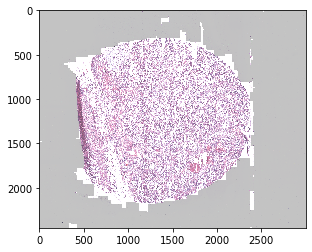

In [33]:
show_newpic(159)

In [8]:
from tqdm import tqdm_notebook as tqdm
import multiprocessing
pool = multiprocessing.Pool(processes = 4)
res = []
pbar = tqdm(total=len(df))
def update(*a):
    res.append(a)
    pbar.update()
    
for i in range(len(df)):
    pool.apply_async(generate_newpic, (i, ), callback=update)
pool.close()
pool.join() 

In [35]:
pool = multiprocessing.Pool(processes = 4)
pbar = tqdm(total=len(list_erro))
for i in list_erro:
    
    pool.apply_async(generate_newpic, (i, ), callback=update)
pool.close()
pool.join() 


In [36]:
len(res)

3220

In [37]:
aaa  = [r[0] for r in res]

In [38]:
res_df = pd.DataFrame.from_dict(aaa, )
res_df.head()

,bboxes,filename,idx,img_mean,img_std
0,"[(430, 379, 1188, 1085), (3823, 335, 1237, 1123)]",TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A...,3,"[228.61025070821808, 224.38440862025843, 229.9...","[33.830615830127954, 44.08051875203392, 30.004..."
1,"[(491, 548, 1523, 1524), (3971, 0, 1619, 1553)]",TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84...,1,"[225.07796348666284, 216.70701147393692, 223.6...","[39.16286973245865, 56.621912863227784, 41.325..."
2,"[(179, 251, 2913, 2580), (2920, 70, 2570, 3416)]",TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7...,0,"[221.05604813618538, 203.45090486728324, 214.3...","[32.08053936044496, 51.58372476519315, 37.4607..."
3,"[(268, 76, 2670, 1727), (4448, 0, 2764, 1756)]",TCGA-O2-A5IB-01A-01-TS1.C35BA437-7DF7-4C5C-8D4...,5,"[218.2473728804718, 209.20708689249554, 218.34...","[45.89415016115524, 61.13321585265162, 43.7285..."
4,"[(0, 65, 6349, 5460)]",TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,2,"[218.8907461822826, 200.31641928860427, 213.94...","[32.71567918618603, 45.08958694885179, 33.7383..."


In [39]:
sorted_res = res_df.sort_values(by='idx')

In [40]:
df_c = df.merge(sorted_res, left_on='FILE_NAME', right_on = 'filename')

In [41]:
df_c.to_csv('tcga_bboxes.csv', sep='\t')

In [47]:
res

[({'idx': 3,
   'img_mean': array([228.61025071, 224.38440862, 229.95955188]),
   'img_std': array([33.83061583, 44.08051875, 30.00466012]),
   'bboxes': [(430, 379, 1188, 1085), (3823, 335, 1237, 1123)],
   'filename': 'TCGA-S2-AA1A-01A-01-TSA.3E0FD5CE-7E85-47A8-80A4-246B10343F4B.svs'},),
 ({'idx': 1,
   'img_mean': array([225.07796349, 216.70701147, 223.693619  ]),
   'img_std': array([39.16286973, 56.62191286, 41.32581939]),
   'bboxes': [(491, 548, 1523, 1524), (3971, 0, 1619, 1553)],
   'filename': 'TCGA-XC-AA0X-01A-03-TS3.6BDA892D-33DC-40F4-A84C-079E08495427.svs'},),
 ({'idx': 0,
   'img_mean': array([221.05604814, 203.45090487, 214.31555803]),
   'img_std': array([32.08053936, 51.58372477, 37.46072129]),
   'bboxes': [(179, 251, 2913, 2580), (2920, 70, 2570, 3416)],
   'filename': 'TCGA-XC-AA0X-01Z-00-DX1.61A34BE0-F16B-4EC1-8E7F-7BF94F6629F4.svs'},),
 ({'idx': 5,
   'img_mean': array([218.24737288, 209.20708689, 218.34428141]),
   'img_std': array([45.89415016, 61.13321585, 43.7

In [57]:
bboxes = []
for r in res:
    bboxes+=r[0]['bboxes']


In [58]:
bboxes

[(430, 379, 1188, 1085),
 (3823, 335, 1237, 1123),
 (491, 548, 1523, 1524),
 (3971, 0, 1619, 1553),
 (179, 251, 2913, 2580),
 (2920, 70, 2570, 3416),
 (268, 76, 2670, 1727),
 (4448, 0, 2764, 1756),
 (0, 65, 6349, 5460),
 (0, 256, 1101, 1372),
 (3665, 0, 1306, 1512),
 (216, 402, 1662, 1300),
 (4615, 301, 1839, 1163),
 (70, 0, 5562, 4636),
 (90, 0, 6230, 5356),
 (90, 0, 5895, 4032),
 (2970, 290, 1730, 1240),
 (205, 72, 1804, 1320),
 (71, 379, 1615, 1843),
 (3715, 228, 1521, 1806),
 (3810, 391, 2378, 1412),
 (280, 106, 2265, 1684),
 (2856, 217, 1158, 1200),
 (230, 180, 1230, 1241),
 (126, 0, 5900, 3968),
 (0, 0, 6184, 5347),
 (3688, 548, 2069, 1459),
 (253, 282, 1957, 1285),
 (5007, 494, 2359, 2947),
 (0, 0, 4876, 4817),
 (136, 0, 4772, 5484),
 (0, 0, 685, 2),
 (572, 222, 2390, 1392),
 (105, 398, 1570, 999),
 (3559, 110, 1634, 1026),
 (124, 454, 1025, 781),
 (3872, 117, 1009, 808),
 (139, 598, 3625, 3906),
 (4150, 73, 3379, 3967),
 (2994, 61, 1623, 1761),
 (132, 56, 1522, 1661),
 (113, 0,

In [59]:
length = [b[2] for b in bboxes]
width = [b[3] for b in bboxes]


(array([ 205.,  691., 1109., 1013.,  454.,  172.,  208.,  235.,  213.,
          58.]),
 array([2.0000e+00, 6.0140e+02, 1.2008e+03, 1.8002e+03, 2.3996e+03,
        2.9990e+03, 3.5984e+03, 4.1978e+03, 4.7972e+03, 5.3966e+03,
        5.9960e+03]),
 <a list of 10 Patch objects>)

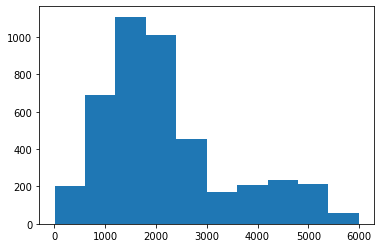

In [62]:
plt.hist(width)

(array([ 893., 1920.,  755.,  284.,  228.,  210.,   54.,    9.,    3.,
           2.]),
 array([   68. ,  1293.7,  2519.4,  3745.1,  4970.8,  6196.5,  7422.2,
         8647.9,  9873.6, 11099.3, 12325. ]),
 <a list of 10 Patch objects>)

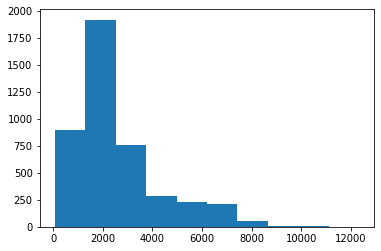

In [63]:
plt.hist(length)

In [27]:
list_erro = set(range(3220))-set(df_c.idx.values)

In [7]:
mdf = df

In [8]:
info_dict={}
[info_dict.update({d[0]['idx']:{'bboxes':d[0]['bboxes'].tolist(), 'pix_percent':d[0]['pix_percent'].tolist(), 'n':d[0]['n'], 'sum_pix_percent':d[0]['sum_pix_percent'], 'trans':d[0]['trans'], 'img_mean':d[0]['img_mean'], 'img_std':d[0]['img_std']}}) for d in res]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [9]:
info_df = pd.DataFrame.from_dict(info_dict,orient='index')

In [10]:
info_df.head()

,bboxes,pix_percent,n,sum_pix_percent,trans,img_mean,img_std
0,"[[429, 817, 108, 77], [415, 971, 97, 77], [453...","[0.07249754535019194, 0.07231319614011684, 0.0...",26,0.999231,False,"[252.92878736413044, 250.7244319897343, 252.55...","[12.211193676908366, 24.977288688090585, 13.98..."
1,"[[561, 563, 72, 77], [525, 640, 104, 77], [420...","[0.10491013820899137, 0.10075971700887375, 0.1...",14,0.998563,False,"[251.41299579326923, 248.18170572916668, 250.9...","[15.36010766657047, 29.12681956468033, 17.0328..."
2,"[[41, 488, 108, 77], [0, 642, 117, 77], [33, 5...","[0.05428915542243525, 0.05372760947957403, 0.0...",21,0.791962,False,"[243.92344642072902, 233.18195713932806, 237.5...","[15.290164402994348, 37.556113633462466, 27.87..."
3,"[[534, 852, 69, 77], [729, 1391, 106, 77], [60...","[0.05076851565073381, 0.04451708966606716, 0.0...",35,0.999101,False,"[252.33473107019555, 250.44485330116296, 252.3...","[12.777608305149922, 20.831410848980145, 12.02..."
4,"[[816, 1881, 115, 77], [772, 1958, 116, 77], [...","[0.035394300115444505, 0.03380837164175771, 0....",59,0.998598,False,"[251.66435107680226, 248.07514932622354, 250.7...","[14.484835796733678, 30.020353908922733, 18.09..."


In [11]:
df2 = pd.concat([mdf, info_df], axis=1)

In [3]:
import os

data_dir = '/mnt/data/PANDA/data/'
image_folder = data_dir + 'train_images'
npy_dir = os.path.join(data_dir, 'train_patchs_npy')
df = pd.read_csv(os.path.join(data_dir, 'train.csv'), sep=',')
df.head()
df2=df


In [4]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(5, shuffle=True, random_state=42)
df2['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df2, df2['isup_grade'])):
    df2.loc[valid_idx, 'fold'] = i
df2.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,4
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [5]:
df2 = df2[df2['image_id']!='3790f55cad63053e956fb73027179707']
df2.to_csv('/mnt/data/PANDA/data/train_detail.csv', index=None)

In [7]:
df2.shape, df.shape

((10615, 5), (10616, 5))

In [14]:
np.array([d[0]['img_mean'] for d in res]).mean(0)

array([248.7002081 , 242.71638743, 245.87125598])

In [15]:
np.array([d[0]['img_std'] for d in res]).mean(0)

array([17.2581289 , 33.26520282, 23.1400218 ])

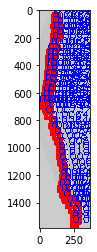

In [21]:
show_newpic(2)

In [12]:
len(pics)

734

In [14]:
kk = np.array(pics)

In [16]:
kk[0].shape

(184, 128, 3)

In [21]:
128*8

1024

/home/hy/anaconda3/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


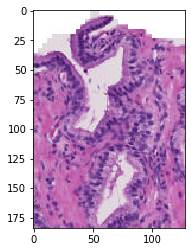

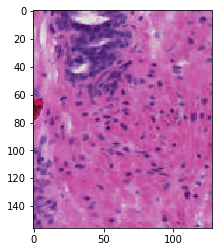

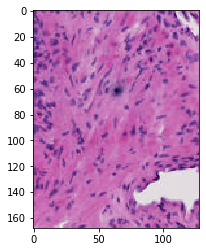

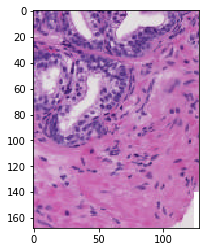

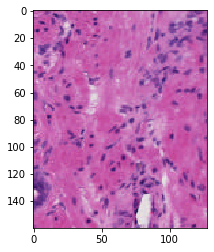

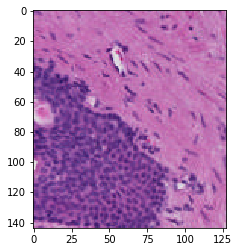

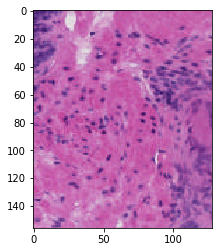

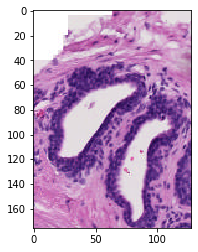

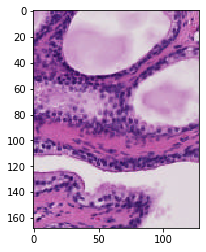

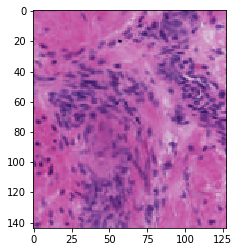

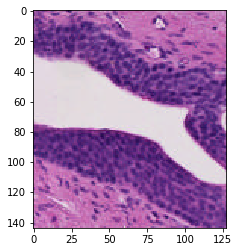

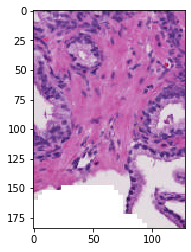

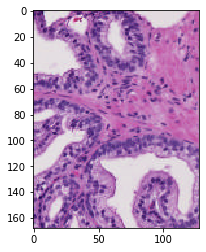

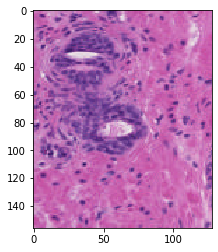

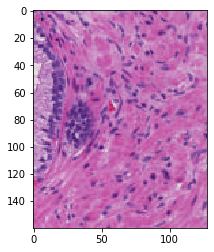

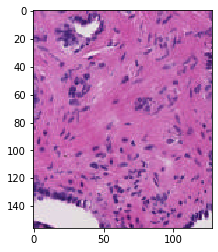

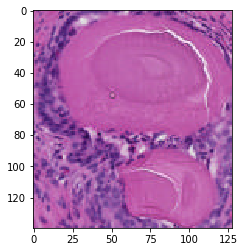

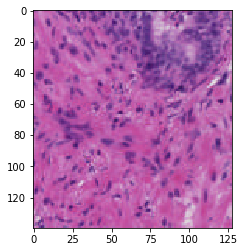

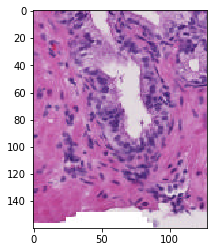

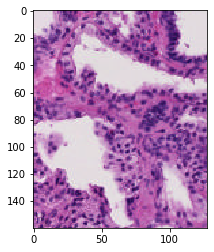

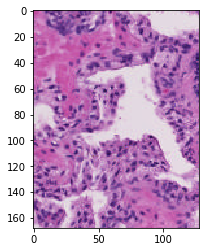

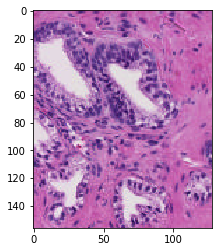

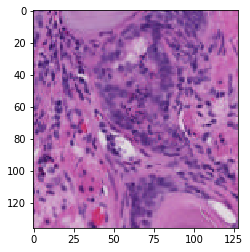

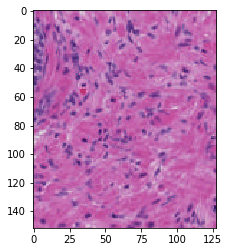

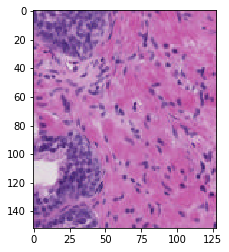

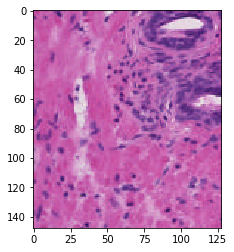

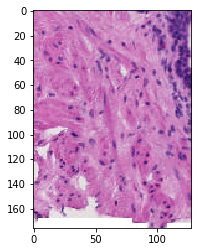

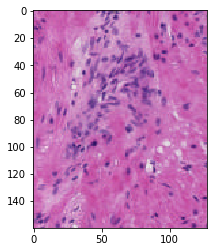

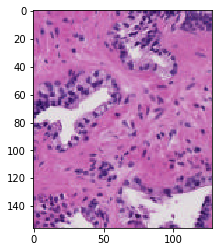

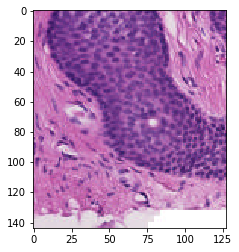

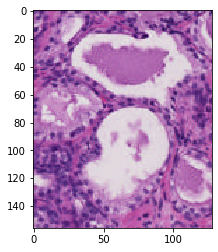

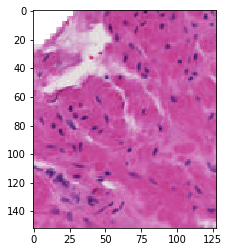

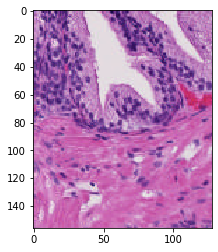

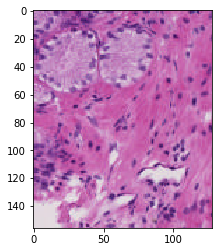

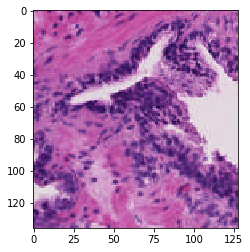

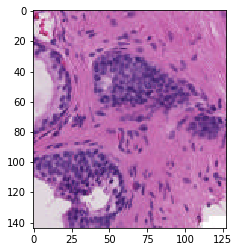

In [18]:
for p in pics[:36]:
    plt.figure()
    plt.imshow(p)